# **Identificación de estrellas pertenecientes a la nebulosa difusa NGC 6357: una aplicación de K-Means**

La nebulosa difusa NGC 6357 corresponde a una región muy peculiar de la constelación Escorpio, debido a que es hogar de múltiples cúmulos abiertos los cuales albergan estrellas inusualmente masivas y brillantes (D. Russeil, et al. 2019). Debido a que este tipo de estrellas suelen corresponder a estrellas particularmente jóvenes y volátiles, la región NGC 6357 se convierte en una zona ideal para estudiar los fenómenos de formación estelar. El efectuar dicho estudio se traduciría en lograr agrupar las diferentes estrellas de la nebulosa en “familias” (es decir, estrellas que hayan nacido juntas: en el mismo lugar y al mismo tiempo), para luego observar las características astrométricas comunes de cada familia y así ordenarlas según en qué estadío de evolución estelar se encuentren. Sin embargo, para lograr este cometido, hay un trabajo previo que se ha de realizar: el de identificar cuáles estrellas **realmente pertenecen a la nebulosa**, diferenciándolas de las estrellas del background/foreground de nuestra línea de visión.

Es **sólo aquella diferenciación inicial recién mencionado** la que corresponde al objetivo de este proyecto.

Específicamente, este trabajo buscará realizar una **clasificación** de estrellas en pertenecientes o no pertenecientes a la nebulosa, y para lograrlo se utilizará una estrategia de **clusterización** mediante **K-Means**. Las especificaciones y justificaciones de la metodología (así como también la presentación y descripción de los datos) serán expuestas conforme se vayan implementando en este notebook (para no saturar de texto a esta primera celda).

El presente notebook está organizado de la siguiente manera:


1.   **Presentación y contextualización de los datos a usar**
2.   **Limpieza y primera exploración de los datos**
3.   **Presentación de la metodología a utilizar y del método de evaluación**
4.   **Aplicación y evaluación de metodología**
5.   **Resultados finales**
6.   **Conclusiones**


Se espera que finalizado el análisis, se puedan presentar como producto final un plot de las coordenadas celestes tanto **de las estrellas que sí pertenecen a la nebulosa, como de las que no pertenecen.**







In [2]:
import pandas as pd
from matplotlib import pyplot as pl
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
%matplotlib inline


In [3]:
#ESTA CELDA ESTÁ COMENTADA PORQUE NO ES NECESARIA PARA CUANDO USTED ESTÉ REVISANDO ESTE REPORTE.

#from google.colab import drive
#drive.mount('/content/drive')
#%cd drive/MyDrive/Académico/Años/2023/Inteligencia Artificial/Proyecto Semestral

Mounted at /content/drive
/content/drive/MyDrive/Académico/Años/2023/Inteligencia Artificial/Proyecto Semestral


# **1-) Presentación y contextualización de los datos a usar**

Los datos que se utilizarán son aquellos del Gaia Data Release 3 (el más actual), el cual es un catálogo que contiene una infinidad de variables astrométricas para cada estrella de cualquier región de la esfera celeste. Para seleccionar las estrellas específicas a estudiar, se localizó el centro geométrico de la nebulosa NGC 6357, y se descargaron los datos de todas las estrellas que cayeran dentro de un radio de 45 arcmin desde dicho centro. Dicha porción específica del GDR3 fue obtenida desde el portal del Strasbourg Astronomical Data Center utilizando el VizieR data retrieval tool (https://vizier.cds.unistra.fr/viz-bin/VizieR), e imponiendo las condiciones geométricas recién mencionadas.

El dataset específico que se utilizará contiene un total de 124.370 estrellas, con 41 variables cada una (excluyendo sus identificadores, pero incluyendo algunas columnas “flag”, como por ejemplo si la estrella es o no es candidata a quásar, etc), en formato tab-separated values.

In [4]:
gdr3 = pd.read_csv('asu.tsv', sep='\t', comment='#')

<ipython-input-4-3836a0120cad>:1: DtypeWarning: Columns (0,1,2,3,4,24,25,26,27,28,29,30,31,32,33,34,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  gdr3 = pd.read_csv('asu.tsv', sep='\t', comment='#')


El dataframe luce como:

In [5]:
gdr3.head()

,RA_ICRS,DE_ICRS,Source,e_RA_ICRS,e_DE_ICRS,Plx,e_Plx,PM,pmRA,e_pmRA,...,MCMCGSP,MCMCMSC,And,Teff,logg,[Fe/H],Dist,A0,RAJ2000,DEJ2000
0,deg,deg,,mas,mas,mas,mas,mas/yr,mas/yr,mas/yr,...,,,,K,[cm/s2],[-],pc,mag,deg,deg
1,---------------,---------------,-------------------,-------,-------,---------,-------,---------,---------,------,...,-,-,-,-------,-------,-------,----------,-------,---------------,---------------
2,260.75793584946,-34.86301091380,5975624317177089920,0.3837,0.2472,1.7125,0.4088,7.501,-1.774,0.465,...,0,0,0,,,,,,260.75794545698,-34.86297852244
3,260.73975476516,-34.85307413789,5975624351536819200,0.9250,0.6268,2.6388,1.0018,20.054,-18.795,1.413,...,0,0,0,,,,,,260.73985655620,-34.85304304893
4,260.75254127497,-34.85571451854,5975624385896564352,1.2330,0.8136,-0.9905,1.5234,3.187,1.659,1.691,...,0,0,0,,,,,,260.75253228901,-34.85572661185


Como las dos primeras filas sólo son información respecto a las unidades, se eliminan para dejar sólamente a los datos numéricos. De todas maneras, más abajo dejaré información sobre cada columna.

In [6]:
gdr3 = gdr3.iloc[2:].reset_index(drop=True)
gdr3.head()

,RA_ICRS,DE_ICRS,Source,e_RA_ICRS,e_DE_ICRS,Plx,e_Plx,PM,pmRA,e_pmRA,...,MCMCGSP,MCMCMSC,And,Teff,logg,[Fe/H],Dist,A0,RAJ2000,DEJ2000
0,260.75793584946,-34.86301091380,5975624317177089920,0.3837,0.2472,1.7125,0.4088,7.501,-1.774,0.465,...,0,0,0,,,,,,260.75794545698,-34.86297852244
1,260.73975476516,-34.85307413789,5975624351536819200,0.9250,0.6268,2.6388,1.0018,20.054,-18.795,1.413,...,0,0,0,,,,,,260.73985655620,-34.85304304893
2,260.75254127497,-34.85571451854,5975624385896564352,1.2330,0.8136,-0.9905,1.5234,3.187,1.659,1.691,...,0,0,0,,,,,,260.75253228901,-34.85572661185
3,260.73074669142,-34.85205315345,5975624557687272960,0.3276,0.1954,1.1379,0.3235,10.872,-5.334,0.380,...,0,0,0,,,,,,260.73077558212,-34.85201104889
4,260.71144825586,-34.84033650532,5975624626414708608,0.8122,0.5349,0.6852,0.6615,1.735,-0.159,1.153,...,0,0,0,,,,,,260.71144911782,-34.84032882808


Las columnas de esta base de datos corresponden a:

In [7]:
gdr3.columns

Index(['RA_ICRS', 'DE_ICRS', 'Source', 'e_RA_ICRS', 'e_DE_ICRS', 'Plx',
       'e_Plx', 'PM', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'RUWE', 'FG', 'e_FG',
       'FBP', 'e_FBP', 'FRP', 'e_FRP', 'BP-RP', 'RV', 'e_RV', 'Vbroad',
       'GRVSmag', 'QSO', 'Gal', 'NSS', 'XPcont', 'XPsamp', 'RVS', 'EpochPh',
       'EpochRV', 'MCMCGSP', 'MCMCMSC', 'And', 'Teff', 'logg', '[Fe/H]',
       'Dist', 'A0', 'RAJ2000', 'DEJ2000'],
      dtype='object')

Las especificaciones de cada columna pueden ser encontradas a continuación:



*   **RA_ICRS:** Ascención Recta [°] (coordenada de posición celeste)
*   **DE_ICRS:** Declinación [°] (coordenada de posición celeste)
*   **Source:** ID del objeto en el catálogo
*   **e_RA_ICRS:** Error de RA_ICRS [miliarcosegundo]
*   **e_DE_ICRS:** Error de DE_ICRS [miliarcosegundo]
*   **Plx:** Paralaje [miliarcosegundo]
*   **e_Plx:** Error de Plx [miliarcosegundo]
*   **PM:** *Proper-motion* [miliarcosegundo/año]
*   **pmRA:** *Proper-motion* en dirección de Ascención Recta [miliarcosegundo/año]
*   **e_pmRA:** Error de pmRA [miliarcosegundo/año]
*   **pmDE:** *Proper-motion* en dirección de Declinación [miliarcosegundo/año]
*   **e_pmDE:** Error de pmDE [miliarcosegundo/año]
*   **RUWE:** Métrica de calidad de la toma de datos del objeto (particular de la misión GAIA) [adim, entre más cercano a 1, mejor calidad]
*   **FG:** Flujo medio en banda Verde [electrones/seg]
*   **e_FG:** Error de FG [electrones/seg]
*   **FBP:** Flujo integrado de fotómetro Azul [electrones/seg]
*   **e_FBP:** Error de FBP [electrones/seg]
*   **FRP:** Flujo integrado de fotómetro Rojo [electrones/seg]
*   **e_FRP:** Error de FRP [electrones/seg]
*   **BP-RP:** Brillo de la estrella [magnitud]
*   **RV:** Velocidad Radial [km/seg]
*   **e_RV:** Error de RV [km/seg]
*   **Vbroad:** Parámetro de ensanchamiento de línea espectral [km/seg]
*   **GRVSmag:** Magnitud integrada de Variabilidad Reducida G [magnitud]
*   **QSO:** Flag que indica si el objeto es candidato a Quásar [bool]
*   **Gal:** Flag que indica si el objeto es candidato a Galaxia [bool]
*   **NSS:** Flag que indica si el objeto pertenece a alguna clasificación de *estrella-no-solitaria* [1-7]
*   **XPcont:** Flag que indica si existe representación continua del espectro promedio BP/RP para este objeto [bool]
*   **XPsamp:** Flag que indica si existe representación discreta del espectro promedio BP/RP para este objeto [bool]
*   **RVS:** Flag que indica si existe espectro medio RVS para este objeto [bool]
*   **EpochPh:** Flag que indica si existe fotometría por épocas para este objeto [bool]
*   **EpochRV:** Flag que indica si existe Velocidad Radial por épocas para este objeto [bool]
*   **MCMCGSP:** Flag que indica si existen muestras de MCMC aplicado a GSP-Phot para este objeto [bool]
*   **MCMCMSC:** Flag que indica si existen muestras de MCMC aplicado a MSC para este objeto [bool]
*   **And:** Flag que indica si el objeto pertenece al catálogo Gaia Andromeda Photometric survey [bool]
*   **Teff:** Temperatura efectiva [°K]
*   **logg:** Gravedad superficial [cm/seg^2]
*   **[Fe/H]:** Abundancia de hierro [adim]
*   **Dist:** Distancia [pársec]
*   **A0:** Extinción monocromática A_0 a 547.7nm [magnitud]
*   **RAJ2000:** Ascención Recta Bariocéntrica en epoch 2000 [°]
*   **DEJ2000:** Declinación Bariocéntrica en epoch 2000 [°]

# **2-) Limpieza y primera exploración de los datos**

Entre todos los parámetros recién mostrados, existen unos cuantos los cuales descartaré durante el desarrollo de este proyecto.

El primer **approach** que quiero darle a este trabajo es un simple algoritmo K-Means, y **no** un **"weighted K-Means"**, por lo que no utilizaré las columnas de errores de las mediciones. Si este primer approach llegase a fallar, consideraré incluirlas.

Otra columna que **no será usada durante la clusterización** es, obviamente, la columna **Source**, ya que sólo corresponden a los identificadores de cada objeto.

Finalmente, tengo 2 pares de columnas que entregan escencialmente la misma información, sólo que con sistemas de referencias distintos (hablo de las columnas **RA_ICRS, DE_ICRS, RAJ2000 y DEJ2000**). Me quedaré con el primer par.

De esta manera, el dataset "usable" corresponderá a:

In [9]:
ids = gdr3['Source'] #Guardo los IDs para cuando toque evaluar (si es que llegase a ser necesario)
columnas_descartadas = ['e_RA_ICRS', 'e_DE_ICRS', 'e_Plx', 'e_pmRA', 'e_pmDE', 'e_FG', 'e_FBP', 'e_FRP', 'e_RV', 'Source', 'RAJ2000', 'DEJ2000']
gdr3_usable = gdr3.drop(columns=columnas_descartadas)
print('Shape del dataset: ', gdr3_usable.shape)
gdr3_usable.head()

Shape del dataset:  (124370, 30)


,RA_ICRS,DE_ICRS,Plx,PM,pmRA,pmDE,RUWE,FG,FBP,FRP,...,EpochPh,EpochRV,MCMCGSP,MCMCMSC,And,Teff,logg,[Fe/H],Dist,A0
0,260.75793584946,-34.86301091380,1.7125,7.501,-1.774,-7.288,0.995,390.90572,6.4678e+01,5.0760e+02,...,0,0,0,0,0,,,,,
1,260.73975476516,-34.85307413789,2.6388,20.054,-18.795,-6.995,1.036,110.09147,2.8744e+01,1.7540e+02,...,0,0,0,0,0,,,,,
2,260.75254127497,-34.85571451854,-0.9905,3.187,1.659,2.721,1.243,121.59748,5.0277e+01,1.9773e+02,...,0,0,0,0,0,,,,,
3,260.73074669142,-34.85205315345,1.1379,10.872,-5.334,-9.474,1.017,429.60368,8.9119e+01,5.4950e+02,...,0,0,0,0,0,,,,,
4,260.71144825586,-34.84033650532,0.6852,1.735,-0.159,-1.727,1.025,152.77580,3.9317e+01,2.1373e+02,...,0,0,0,0,0,,,,,


Este dataset contiene casillas en blanco las cuales **NO** son leídas como Nans. Como quiero contar los Nans, forzaré a que cada valor no numérico del dataframe sea expresado como un Nan.

In [10]:
for i in gdr3_usable.columns.values:
  gdr3_usable[i] = pd.to_numeric(gdr3_usable[i], errors='coerce')

In [11]:
gdr3_usable.head()

,RA_ICRS,DE_ICRS,Plx,PM,pmRA,pmDE,RUWE,FG,FBP,FRP,...,EpochPh,EpochRV,MCMCGSP,MCMCMSC,And,Teff,logg,[Fe/H],Dist,A0
0,260.757936,-34.863011,1.7125,7.501,-1.774,-7.288,0.995,390.90572,64.678,507.60,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
1,260.739755,-34.853074,2.6388,20.054,-18.795,-6.995,1.036,110.09147,28.744,175.40,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
2,260.752541,-34.855715,-0.9905,3.187,1.659,2.721,1.243,121.59748,50.277,197.73,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
3,260.730747,-34.852053,1.1379,10.872,-5.334,-9.474,1.017,429.60368,89.119,549.50,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN
4,260.711448,-34.840337,0.6852,1.735,-0.159,-1.727,1.025,152.77580,39.317,213.73,...,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN


Ahora, procedo a explorar un poco la distribución de cada parámetro. Para eso, crearé una pequeña función que me entregue el porcentaje de NaNs que haya por cada columna.

In [12]:
def nanpercent(x):
  total = len(gdr3_usable[x].values)
  cantidad_nans = gdr3_usable[x].isna().sum()
  print('Porcentaje de NaNs en '+x+':', cantidad_nans*100/total)

In [13]:
for i in gdr3_usable.columns.values:
  nanpercent(i)

Porcentaje de NaNs en RA_ICRS: 0.0
Porcentaje de NaNs en DE_ICRS: 0.0
Porcentaje de NaNs en Plx: 23.517729355954007
Porcentaje de NaNs en PM: 23.517729355954007
Porcentaje de NaNs en pmRA: 23.517729355954007
Porcentaje de NaNs en pmDE: 23.517729355954007
Porcentaje de NaNs en RUWE: 23.517729355954007
Porcentaje de NaNs en FG: 1.6579560987376376
Porcentaje de NaNs en FBP: 9.32942027820214
Porcentaje de NaNs en FRP: 5.905765055881644
Porcentaje de NaNs en BP-RP: 9.343089169413846
Porcentaje de NaNs en RV: 98.15550373884378
Porcentaje de NaNs en Vbroad: 99.83838546273218
Porcentaje de NaNs en GRVSmag: 98.23751708611401
Porcentaje de NaNs en QSO: 0.0
Porcentaje de NaNs en Gal: 0.0
Porcentaje de NaNs en NSS: 0.0
Porcentaje de NaNs en XPcont: 0.0
Porcentaje de NaNs en XPsamp: 0.0
Porcentaje de NaNs en RVS: 0.0
Porcentaje de NaNs en EpochPh: 0.0
Porcentaje de NaNs en EpochRV: 0.0
Porcentaje de NaNs en MCMCGSP: 0.0
Porcentaje de NaNs en MCMCMSC: 0.0
Porcentaje de NaNs en And: 0.0
Porcentaje de

Se puede observar que existen algunas columnas donde falta **casi la totalidad de los datos**. Cada una de esas columnas será descartada.


In [14]:
columnas_descartadas = ['RV', 'Vbroad', 'GRVSmag', 'Teff', 'logg', '[Fe/H]', 'Dist', 'A0']
gdr3_usable = gdr3_usable.drop(columns=columnas_descartadas)
gdr3_usable.head()

,RA_ICRS,DE_ICRS,Plx,PM,pmRA,pmDE,RUWE,FG,FBP,FRP,...,Gal,NSS,XPcont,XPsamp,RVS,EpochPh,EpochRV,MCMCGSP,MCMCMSC,And
0,260.757936,-34.863011,1.7125,7.501,-1.774,-7.288,0.995,390.90572,64.678,507.60,...,0,0,0,0,0,0,0,0,0,0
1,260.739755,-34.853074,2.6388,20.054,-18.795,-6.995,1.036,110.09147,28.744,175.40,...,0,0,0,0,0,0,0,0,0,0
2,260.752541,-34.855715,-0.9905,3.187,1.659,2.721,1.243,121.59748,50.277,197.73,...,0,0,0,0,0,0,0,0,0,0
3,260.730747,-34.852053,1.1379,10.872,-5.334,-9.474,1.017,429.60368,89.119,549.50,...,0,0,0,0,0,0,0,0,0,0
4,260.711448,-34.840337,0.6852,1.735,-0.159,-1.727,1.025,152.77580,39.317,213.73,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#Cuento los Nans una vez más para verificcación:
for i in gdr3_usable.columns.values:
  nanpercent(i)

Porcentaje de NaNs en RA_ICRS: 0.0
Porcentaje de NaNs en DE_ICRS: 0.0
Porcentaje de NaNs en Plx: 23.517729355954007
Porcentaje de NaNs en PM: 23.517729355954007
Porcentaje de NaNs en pmRA: 23.517729355954007
Porcentaje de NaNs en pmDE: 23.517729355954007
Porcentaje de NaNs en RUWE: 23.517729355954007
Porcentaje de NaNs en FG: 1.6579560987376376
Porcentaje de NaNs en FBP: 9.32942027820214
Porcentaje de NaNs en FRP: 5.905765055881644
Porcentaje de NaNs en BP-RP: 9.343089169413846
Porcentaje de NaNs en QSO: 0.0
Porcentaje de NaNs en Gal: 0.0
Porcentaje de NaNs en NSS: 0.0
Porcentaje de NaNs en XPcont: 0.0
Porcentaje de NaNs en XPsamp: 0.0
Porcentaje de NaNs en RVS: 0.0
Porcentaje de NaNs en EpochPh: 0.0
Porcentaje de NaNs en EpochRV: 0.0
Porcentaje de NaNs en MCMCGSP: 0.0
Porcentaje de NaNs en MCMCMSC: 0.0
Porcentaje de NaNs en And: 0.0


Ahora sí se tiene una cantidad reducida de Nans. De hecho, pareciera ser que las columnas que más Nans tienen corresponden a los mismos objetos. Por ende, dropearé los Nans restantes.

In [16]:
gdr3_final = gdr3_usable.dropna()
gdr3_final.shape

(90575, 22)

Finalmente queda con la decente candidad de cerca de 90mil estrellas, y 22 parámetros. A continuación, se hará una pequeña exploración sobre la distribución de los parámetros restantes.



**Las coordenadas celestes:**

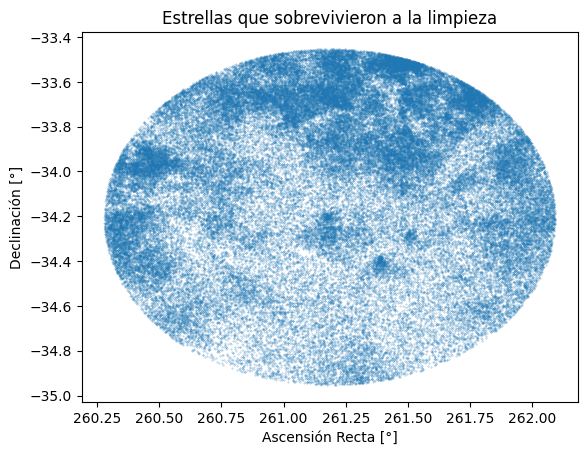

In [17]:
pl.scatter(gdr3_final['RA_ICRS'], gdr3_final['DE_ICRS'], s=0.1, alpha=0.5)
pl.xlabel('Ascensión Recta [°]')
pl.ylabel('Declinación [°]')
pl.title('Estrellas que sobrevivieron a la limpieza')
pl.show()

Como se puede observar, hay pequeñas regiones en donde **aparentemente** se concentran más estrellas. Recalco el **"aparantemente"** puesto que no se sabe si dichas aglomeraciones están realmente compuestas por estrellas que estén **cerca las unas de otras**, o simplemente se **superponen en nuestra línea de visión**.

**El Paralaje:**

**[Pequeño spoiler]:** Esta variable es la más **importante de todas**. El paralaje es una medición de qué tanto cambia la **posición aparente** de un objeto conforme pasa el tiempo. Es decir, esta métrica está directamente relacionada con la **distancia a la que estamos de un cuerpo**. Por lo tanto, mi estrategia será utilizar esta variable como **variable de validación** del algoritmo.

Me explico:

Se supone que para que las estrellas pertenezcan a la nebulosa, éstas deben cumplir dos requisitos: uno, que **"se parezcan"** entre ellas (de lo cual se encargará la clusterización K-means), y segundo, que estén **cerca** las unas de otras. Por lo tanto, lo que pienso hacer es primero entrenar el algoritmo K-means, y luego verificar que los clústeres que se calculen **tengan valores cercanos en el espacio de paralajes** (o, dicho de otro modo, que sus paralajes **tengan una dispersión "angosta"**). De esta manera, podré saber si los clústeres calculados por K-means se condicen con el comportamiento esperado o no (más adelante explicaré mi approach para elegir el número K).

Por lo tanto, vale la pena echarle un primer vistazo al **espacio de paralajes:**

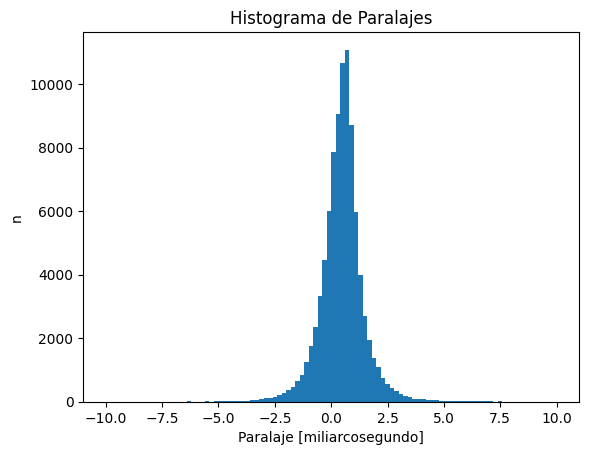

In [18]:
pl.hist(gdr3_final['Plx'], bins=100, range=(-10, 10))
pl.xlabel('Paralaje [miliarcosegundo]')
pl.ylabel('n')
pl.title('Histograma de Paralajes')
pl.show()

Se puede observar que existe un peak de paralajes cercano a los 1.0 miliarcosegundos. Será tarea del algoritmo K-means determinar si este peak corresponde o no corresponde a las estrellas pertenecientes a la nebulosa.

**El Proper-Motion:**

Las estrellas que pertenecen a la misma nebulosa deberían tener proper-motions parecidos (aunque, de nuevo, será tarea de K-means definir "parecido"). Aún así, se puede echar un vistazo a la distribución de este variable:

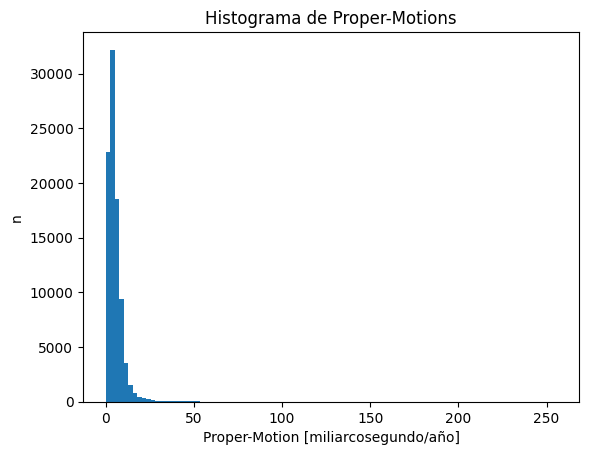

In [19]:
pl.hist(gdr3_final['PM'], bins=100, range=(gdr3_final['PM'].values.min(), gdr3_final['PM'].values.max()))
pl.xlabel('Proper-Motion [miliarcosegundo/año]')
pl.ylabel('n')
pl.title('Histograma de Proper-Motions')
pl.show()

Al igual que con los paralajes, se observa cierto peak de Proper-Motions que podrían corresponder a estrellas vecinas.

**El brillo:**

Una última característica importante que las estrellas de una misma nebulosa deben compartir (hasta cierta medida) es el **brillo**, por lo cual se grafica el histograma a continuación:

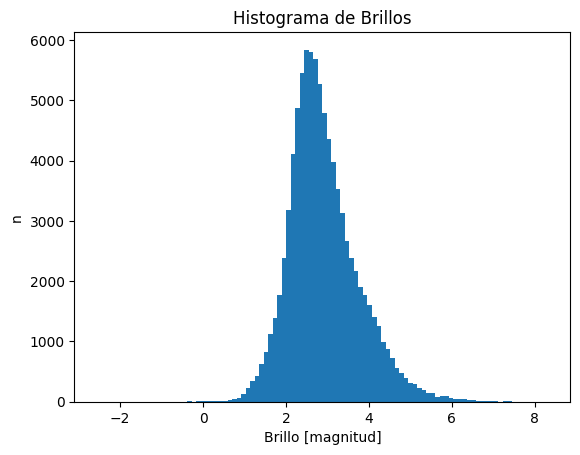

In [20]:
pl.hist(gdr3_final['BP-RP'], bins=100, range=(gdr3_final['BP-RP'].values.min(), gdr3_final['BP-RP'].values.max()))
pl.xlabel('Brillo [magnitud]')
pl.ylabel('n')
pl.title('Histograma de Brillos')
pl.show()

**Estudio de correlaciones:**

Para hacer un estudio de correlaciones y ver si alguna variable "sobra", primero es necesario **estandarizar** los datos:

In [21]:
std = StandardScaler()
gdr3_scaled = std.fit_transform(gdr3_final)
gdr3_scaled = pd.DataFrame(gdr3_scaled, columns=gdr3_final.columns)
gdr3_scaled

,RA_ICRS,DE_ICRS,Plx,PM,pmRA,pmDE,RUWE,FG,FBP,FRP,...,Gal,NSS,XPcont,XPsamp,RVS,EpochPh,EpochRV,MCMCGSP,MCMCMSC,And
0,-0.931193,-2.287735,1.188770,0.412341,-0.057907,-0.722262,-0.200030,-0.020745,-0.015412,-0.028318,...,-0.005755,-0.017131,-0.408924,-0.162457,0.0,-0.141625,0.0,-0.537479,-0.526136,0.0
1,-0.969717,-2.260479,2.084594,2.809169,-4.347255,-0.661792,-0.131638,-0.021587,-0.015581,-0.029981,...,-0.005755,-0.017131,-0.408924,-0.162457,0.0,-0.141625,0.0,-0.537479,-0.526136,0.0
2,-0.942623,-2.267721,-1.425301,-0.411359,0.807221,1.343423,0.213658,-0.021553,-0.015480,-0.029869,...,-0.005755,-0.017131,-0.408924,-0.162457,0.0,-0.141625,0.0,-0.537479,-0.526136,0.0
3,-0.988805,-2.257679,0.633074,1.055989,-0.955038,-1.173415,-0.163332,-0.020629,-0.015297,-0.028108,...,-0.005755,-0.017131,-0.408924,-0.162457,0.0,-0.141625,0.0,-0.537479,-0.526136,0.0
4,-1.029697,-2.225541,0.195268,-0.688599,0.349079,0.425432,-0.149987,-0.021459,-0.015532,-0.029789,...,-0.005755,-0.017131,-0.408924,-0.162457,0.0,-0.141625,0.0,-0.537479,-0.526136,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90570,-0.711033,1.439258,2.443195,2.468920,4.989216,0.949025,0.051852,-0.010391,-0.011236,-0.008696,...,-0.005755,-0.017131,2.445444,-0.162457,0.0,-0.141625,0.0,1.860538,1.900649,0.0
90571,-0.716400,1.424495,0.196622,-0.160278,0.076663,-0.111370,-0.205034,-0.021241,-0.015591,-0.029036,...,-0.005755,-0.017131,-0.408924,-0.162457,0.0,-0.141625,0.0,-0.537479,-0.526136,0.0
90572,-0.700123,1.447884,0.123703,0.064455,-0.274125,-0.256869,-0.113289,-0.016546,-0.014334,-0.016403,...,-0.005755,-0.017131,2.445444,-0.162457,0.0,-0.141625,0.0,-0.537479,1.900649,0.0
90573,-0.716499,1.432540,-0.260043,-0.563345,0.687267,0.352992,0.020159,-0.021502,-0.015550,-0.029924,...,-0.005755,-0.017131,-0.408924,-0.162457,0.0,-0.141625,0.0,-0.537479,-0.526136,0.0


In [22]:
#Y ahora se buscan pares de variables cuya correlación sea buena:

corr_matrix = gdr3_scaled.corr()
good_corrs = abs(corr_matrix) > 0.95
good_corrs.sum()

RA_ICRS    1
DE_ICRS    1
Plx        1
PM         1
pmRA       1
pmDE       1
RUWE       1
FG         3
FBP        2
FRP        2
BP-RP      1
QSO        1
Gal        1
NSS        1
XPcont     1
XPsamp     1
RVS        0
EpochPh    1
EpochRV    0
MCMCGSP    1
MCMCMSC    1
And        0
dtype: int64

Se ve que hay algunos pares de variables que sí tienen buena correlación con otros, como es el caso de FG, FBP y FRP. Los estudiaré uno por uno:

In [23]:
corr_matrix['FG']

RA_ICRS    0.001854
DE_ICRS   -0.013225
Plx        0.091548
PM         0.074677
pmRA       0.009771
pmDE      -0.078532
RUWE       0.017033
FG         1.000000
FBP        0.979510
FRP        0.963628
BP-RP     -0.040918
QSO        0.009565
Gal       -0.000123
NSS        0.037957
XPcont     0.049916
XPsamp     0.115392
RVS             NaN
EpochPh    0.004544
EpochRV         NaN
MCMCGSP    0.013026
MCMCMSC    0.039899
And             NaN
Name: FG, dtype: float64

Se observa que FG, FBP y FRP tienen una alta correlación entre sí, lo cual indica que entregan escencialmente la misma información cada uno. Por lo tanto, eliminaré las columnas FBP y FRP, y me quedaré sólo con FG.

In [24]:
gdr3_scaled= gdr3_scaled.drop(columns=['FBP', 'FRP'])
#Y calculo nuevamente las correlaciones buenas para cerciorarme:

corr_matrix = gdr3_scaled.corr()
good_corrs = abs(corr_matrix) > 0.95
good_corrs.sum()

RA_ICRS    1
DE_ICRS    1
Plx        1
PM         1
pmRA       1
pmDE       1
RUWE       1
FG         1
BP-RP      1
QSO        1
Gal        1
NSS        1
XPcont     1
XPsamp     1
RVS        0
EpochPh    1
EpochRV    0
MCMCGSP    1
MCMCMSC    1
And        0
dtype: int64

Sin embargo, sigue habiendo un comportamiento raro con RVS, EpochRV y And, por lo que les echaré un vistazo.

In [25]:
print(gdr3_scaled['RVS'].sum(), gdr3_scaled['EpochRV'].sum(), gdr3_scaled['And'].sum())

0.0 0.0 0.0


¡Ninguna de esas tres flags tiene siquiera un solo "1"! ¡Son todas cero! Por lo tanto, no entregan nada de información sobre la variabilidad de los objetos, y pueden ser columnas descartadas.

In [26]:
gdr3_scaled_clean = gdr3_scaled.drop(columns=['RVS', 'EpochRV', 'And'])
#Finalmente, el dataset limpio corresponde a:
gdr3_scaled_clean

,RA_ICRS,DE_ICRS,Plx,PM,pmRA,pmDE,RUWE,FG,BP-RP,QSO,Gal,NSS,XPcont,XPsamp,EpochPh,MCMCGSP,MCMCMSC
0,-0.931193,-2.287735,1.188770,0.412341,-0.057907,-0.722262,-0.200030,-0.020745,-0.098199,-0.009399,-0.005755,-0.017131,-0.408924,-0.162457,-0.141625,-0.537479,-0.526136
1,-0.969717,-2.260479,2.084594,2.809169,-4.347255,-0.661792,-0.131638,-0.021587,-0.423413,-0.009399,-0.005755,-0.017131,-0.408924,-0.162457,-0.141625,-0.537479,-0.526136
2,-0.942623,-2.267721,-1.425301,-0.411359,0.807221,1.343423,0.213658,-0.021553,-0.991231,-0.009399,-0.005755,-0.017131,-0.408924,-0.162457,-0.141625,-0.537479,-0.526136
3,-0.988805,-2.257679,0.633074,1.055989,-0.955038,-1.173415,-0.163332,-0.020629,-0.409998,-0.009399,-0.005755,-0.017131,-0.408924,-0.162457,-0.141625,-0.537479,-0.526136
4,-1.029697,-2.225541,0.195268,-0.688599,0.349079,0.425432,-0.149987,-0.021459,-0.572819,-0.009399,-0.005755,-0.017131,-0.408924,-0.162457,-0.141625,-0.537479,-0.526136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90570,-0.711033,1.439258,2.443195,2.468920,4.989216,0.949025,0.051852,-0.010391,-0.772446,-0.009399,-0.005755,-0.017131,2.445444,-0.162457,-0.141625,1.860538,1.900649
90571,-0.716400,1.424495,0.196622,-0.160278,0.076663,-0.111370,-0.205034,-0.021241,0.617521,-0.009399,-0.005755,-0.017131,-0.408924,-0.162457,-0.141625,-0.537479,-0.526136
90572,-0.700123,1.447884,0.123703,0.064455,-0.274125,-0.256869,-0.113289,-0.016546,0.194930,-0.009399,-0.005755,-0.017131,2.445444,-0.162457,-0.141625,-0.537479,1.900649
90573,-0.716499,1.432540,-0.260043,-0.563345,0.687267,0.352992,0.020159,-0.021502,-0.613313,-0.009399,-0.005755,-0.017131,-0.408924,-0.162457,-0.141625,-0.537479,-0.526136


# **3-) Presentación de la metodología a ocupar y del método de evaluación**

Como bien se ha dicho hasta ahora, el objetivo de este experimento es determinar cuáles estrellas pertenecen a la nebulosa NGC 6357 mediante un algoritmo K-means.

La pregunta natural que aflora es: **¿cómo elegir el número K?** Esta pregunta se torna aún más importante al considerar que en una **misma nebulosa** pueden coexistir **varios clústeres de estrellas**. O sea, fácilmente podríamos poner un número "alto" para K y encontraríamos clústeres que viven cerca del mismo espacio en el continuo de paralajes, y otros que no.

La determinación de K es probablemente la parte más heurística de este proyecto, por lo cual se me ocurrieron dos maneras de abordar el problema:

1) Utilizar **PCA** con el fin de obtener las componentes principales con mayor variabilidad, y graficarlas unas contra otras. Así, obtendré gráficos en los cuales podré visualmente **"contar"** el número de aglomeraciones que se formen, y definir dicho número como el número K para el algoritmo de K-means.

2) Si el primer approach no funciona, podría elegir un **número K dinámico** y **definir alguna métrica** para la **"distancia media entre centroides"**, y elevar el número K hasta que dicha distancia media deje de variar considerablemente. Este approach será un tanto más engorroso, por eso lo dejo como segunda opción.

Para ambas metodologías, el método de evaluación será el mismo:

Si el algoritmo K-means encuentra clústeres que **además** comparten valores cercanos de paralaje (y que habiten más o menos entre los +/-0.5 miliarcosegundos, que es la distancia teórica de la Nebulosa NGC 6357) dichos objetos corresponderán a estrellas que viven en la nebulosa. Los objetos que compartan un clúster de K-means pero que NO vivan cercanos los unos a los otros corresponderían a objetos que simplemente se superpusieron en nuestra línea de visión con la nebulosa.

Ahora, en el hipotético (y catastrófico caso) de que ningún clúster calculado comparta valores similares de paralaje, entonces la hipótesis que fundamenta esta metodología se vería refutada.

#   **4-) Aplicación y evaluación de metodología**

**Primer approach: usando PCA para determinar K:**

In [28]:
#Antes que nada, se excluye la columna "Plx" de los datos que se usarán para la clusterización, ya que ella será usada para validación:
gdr3_train = gdr3_scaled_clean.drop(columns=['Plx'])

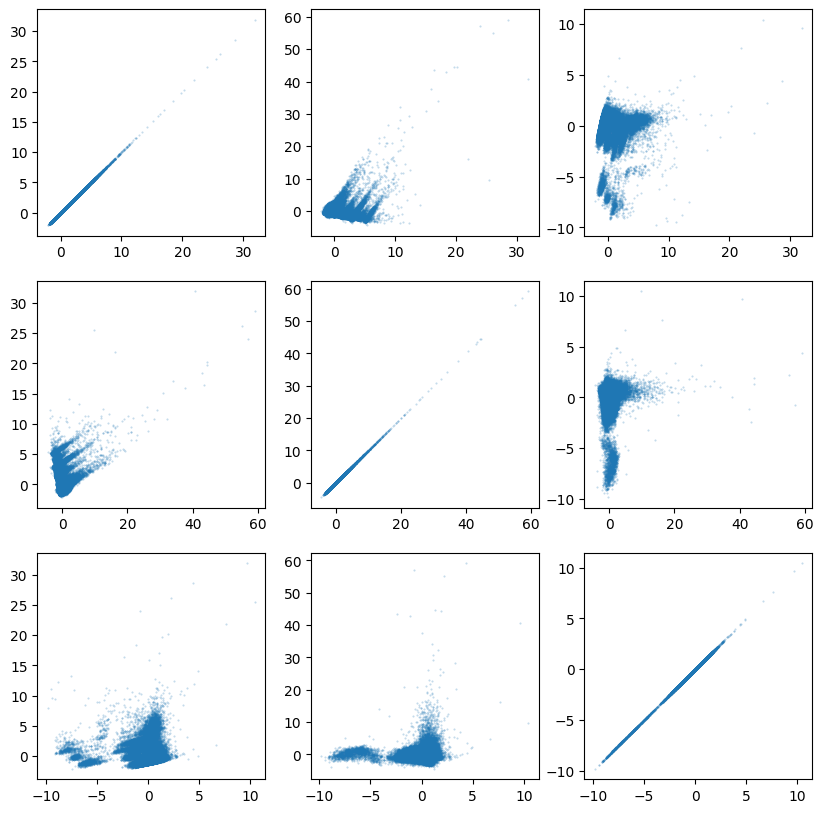

In [30]:
pca = PCA(n_components = 3) #Quiero reducir a sólo 3 componentes principales
PC = pca.fit_transform(gdr3_train)
n_components = PC.shape[1]


#Ahora hago un pequeño código para graficar todas las componentes principales versus las otras:
fig, axes = pl.subplots(n_components, n_components)
for i in range(0, n_components):
  for j in range(0, n_components):
    axes[i][j].scatter(PC[:, i], PC[:, j], s=0.2, alpha=0.3)
fig.set_size_inches(10, 10)
fig.show()

Puedo observar que **muy al ojímetro** hay aparentemente dos clústers. Por lo tanto, entrenaré el algoritmo de K-means utilizando K=2 y dependiendo de qué tan bien resulte la validación, barajaré la posibilidad de utilizar un K dinámico. Este es el enfoque más rústico para determinar K.

Ahora, se pasará a correr al algoritmo:

In [31]:
k_means = KMeans(n_clusters=2, random_state=13) #Entreno el modelo
k_means.fit(gdr3_train.values)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=13)

A continuación, revisaré cómo han quedado clasificadas las estrellas en un histograma de sus respectivos paralajes. Recordar que en el mejor de los casos, el paralaje de las estrellas que SÍ pertenezcan a la nebulosa debería tener una dispersión relativamente angosta, y cercana a los +/-0.5 miliarcosegundos.



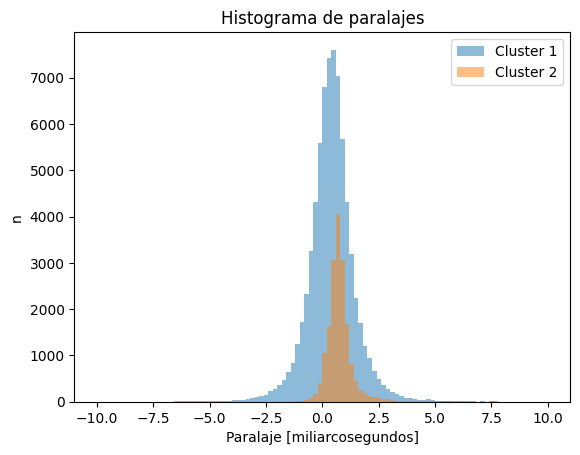

In [32]:
labels = k_means.labels_

pl.hist(gdr3_final['Plx'][labels==0], bins=100, range=(-10, 10), alpha=0.5, label='Cluster 1')
pl.hist(gdr3_final['Plx'][labels==1], bins=100, range=(-10, 10), alpha=0.5, label='Cluster 2')
pl.xlabel('Paralaje [miliarcosegundos]')
pl.ylabel('n')
pl.title('Histograma de paralajes')
pl.legend()
pl.show()

¡El segundo clúster presenta una **dispersión menor de paralajes**! Esto podría indicar que, efectivamente, el clúster 2 corresponde a **aquellas estrellas que pertenecen a la Nebulosa NGC 6357**, mientras que el clúster 1 podría entonces corresponder a las estrellas que simplemente se superpusieron con la nebulosa en nuestra línea de visión.

Sin embargo, **hay un problema:** se sabe que la Nebulosa NGC 6357 se encuentra a cerca de **1800 pársecs de distancia**, lo cual equivale a cerca de +/- 0.5 miliarcosegundos. En contraste, el histograma del clúster 2 presenta una anchura de más o menos 2 miliarcosegundos, lo cual **no se condice** con la teoría.

Es decir, este **primer approach** ha resultado ser ineficiente.


Por lo tanto, se procederá con el segundo approach propuesto.

**Segundo approach: Usando un K dinámico**

Para seguir este segundo approach, utilizaré "la técnica del codo". Es decir, por cada modelo de KMeans que entrene, guardaré el dato de **la distancia promedio entre centroides**. Luego, graficaré el número de clústeres vs. las distancias promedios y elegiré el número K en el cual se produzca el "codo" del gráfico (o sea, el punto en el cual las distancias entre centroides dejan de variar tanto).

Utilizaré 11 valores para K: desde 2 hasta 13:



In [33]:
valores_k = range(2, 14)

In [34]:
distancias = []
for k in valores_k:
  kmeans2 = KMeans(n_clusters=k, random_state=13)
  kmeans2.fit(gdr3_train.values)
  distancias.append(kmeans2.inertia_) #el valor "inertia" corresponde a la distancia promedio entre centroides


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

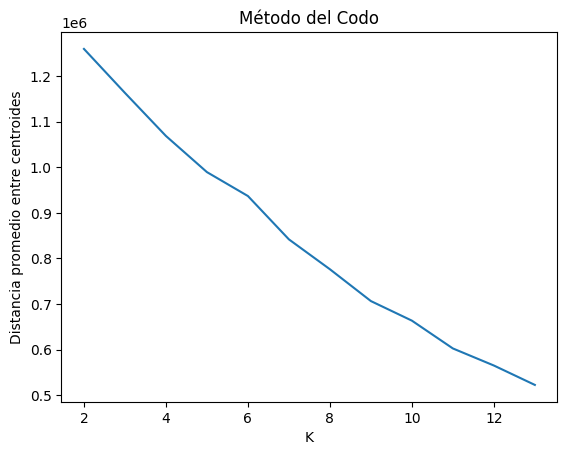

In [35]:
#Ahora haré el gráfico:

pl.plot(valores_k, distancias)
pl.xlabel('K')
pl.ylabel('Distancia promedio entre centroides')
pl.title('Método del Codo')
pl.show()

Lamentablemente, se observa que nunca hay un codo. Por lo tanto, lo que haré será ir probando distintos valores de K desde 3 hasta 6 simplemente (decisión completamente arbitraria), e ir indagando en cómo se distribuyen dichos clústeres en el espacio de paralajes.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


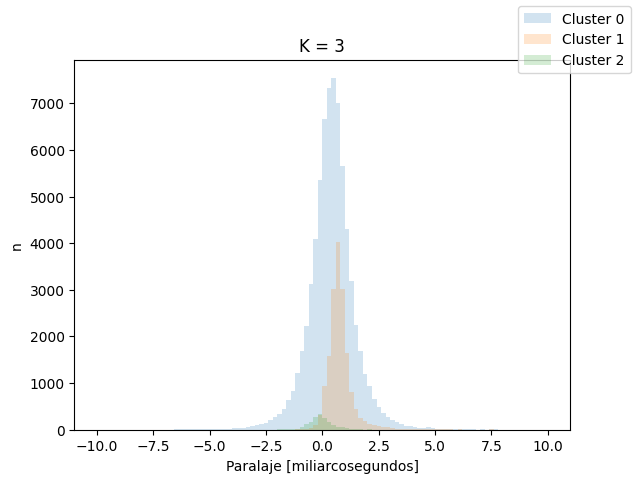

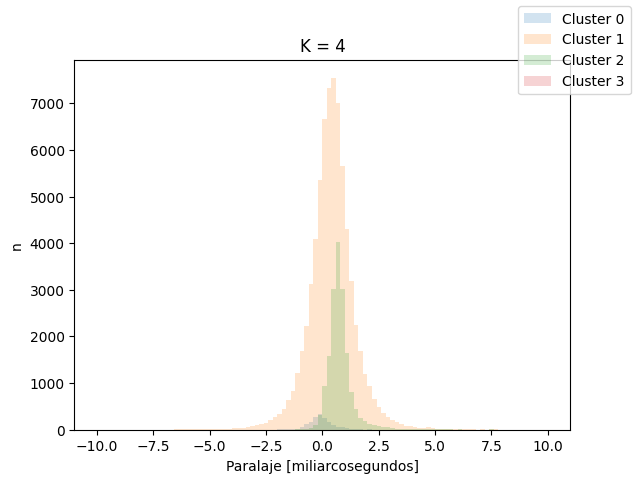

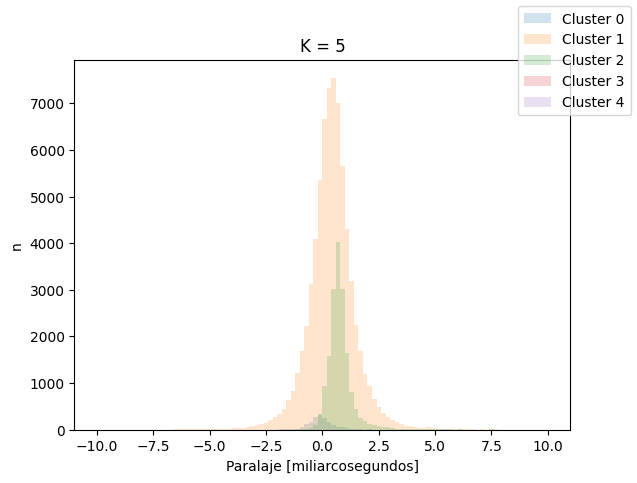

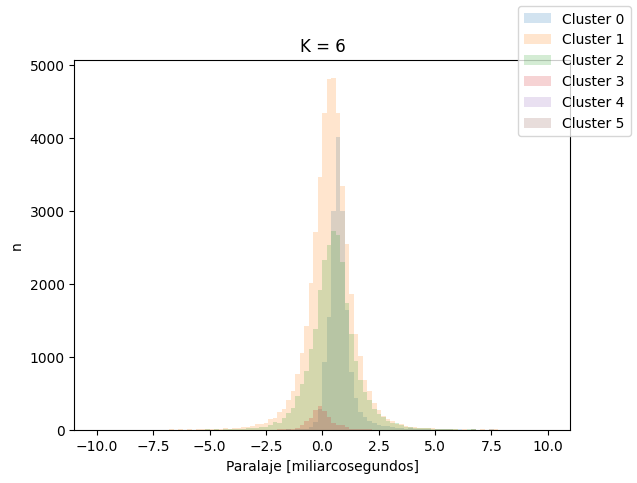

In [36]:
all_labels = []

for k in range(3, 7):
  kmeans3 = KMeans(n_clusters = k, random_state=13) #Entreno el modelo
  kmeans3.fit(gdr3_train.values)
  dynamic_labels = kmeans3.labels_ #Rescato las labels
  all_labels.append(dynamic_labels)

  fig, ax = pl.subplots(1)

  for i in range(0, k):  #Ahora grafico los paralajes de manera reiterativa

    ax.hist(gdr3_final['Plx'][dynamic_labels==i], bins=100, alpha=0.2, range=(-10, 10), label='Cluster '+str(i))

  ax.set_xlabel('Paralaje [miliarcosegundos]')
  ax.set_ylabel('n')
  ax.set_title('K = '+str(k))
  fig.legend()
  fig.show()





Se puede observar que en cada uno de los gráficos existe consistentemente una zona entre los -0.5 y +0.5 miliarcosegundos en la cual reside una pequeña porción de los datos. Para asegurarme que dichos clústeres pequeños contengan a exactamente los mismos datos para cada uno de los 4 gráficos, elaboraré una pequeña función comparadora:

In [37]:
def compare(label1, index1, label2, index2):
  max_len = max(len(gdr3_final['RA_ICRS'].values[label1==index1]), len(gdr3_final['RA_ICRS'].values[label2==index2])) #Calculo cuál de los dos labels tiene más datos

  matches = len(np.intersect1d(gdr3_final['RA_ICRS'].values[label1==index1], gdr3_final['RA_ICRS'].values[label2==index2])) #Veo los matches de RA_ICRS

  matches_perc = matches*100.0/max_len #calculo el porcentaje de matches entre ambos arrays
  return matches_perc

Observando los gráficos, se ve que para el primer gráfico (K=3), el pequeño clúster que habita entre -0.5 y +0.5 miliarcosegundos corresponde al clúster número 2. Luego, para el segundo gráfico (K=4) dicho clúster corresponde al clúster 0. Por ende, comparándolos:

In [38]:
print('Porcentaje de matches: ', compare(all_labels[0], 2, all_labels[1], 0))

Porcentaje de matches:  100.0


¡Ambos clústeres tienen los mismos datos! Comparemos a uno de ellos con el clúster 0 del tercer gráfico (K=5)

In [39]:
print('Porcentaje de matches: ', compare(all_labels[0], 2, all_labels[2], 0))

Porcentaje de matches:  99.83155530600786


¡Nuevamente son prácticamente idénticos! Comparándolo finalmente ahora con el clúster 3 del cuarto gráfico (K=6):

In [40]:
print('Porcentaje de matches: ', compare(all_labels[0], 2, all_labels[3], 3))

Porcentaje de matches:  99.83155530600786


¡Nuevamente prácticamente idénticos!

# **5-) Resultados finales**

Como se pudo observar, a partir de un valor K=3 en adelante existió siempre un pequeño clúster que habitaba entre +/- 0.5 miliarcosegundos, lo cual equivale a aproximadamente 1800 pársecs, que es la distancia a la cual se encuentra la nebulosa. Por lo tanto, **se podría entonces concluir que dicho clúster corresponde a las estrellas pertenecientes a la nebulosa NGC 6357**.

Ahora, para cumplir con el objetivo final de este proyecto, se procederá a graficar las coordenadas celestes tanto de las estrellas pertenecientes a la Nebulosa, como de las que no.

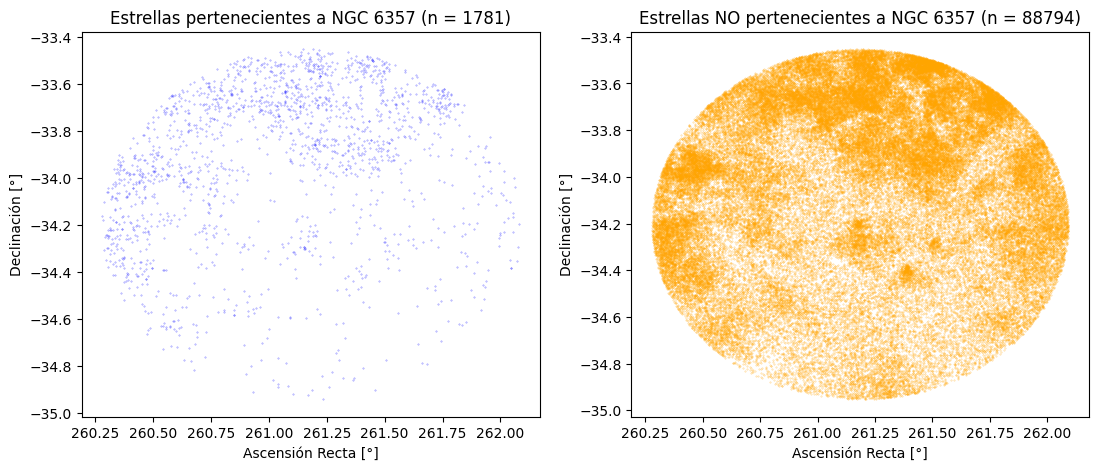

In [41]:
n1 = sum(all_labels[0]==2) #Para los títulos
n2 = sum(all_labels[0]!=2)

#COORDENADAS CELESTES

fig, ax = pl.subplots(1, 2)
ax[0].scatter(gdr3_final['RA_ICRS'][all_labels[0]==2], gdr3_final['DE_ICRS'][all_labels[0]==2], c='blue', s=0.1, alpha=0.5)
ax[0].set_xlabel('Ascensión Recta [°]')
ax[0].set_ylabel('Declinación [°]')
ax[0].set_title('Estrellas pertenecientes a NGC 6357 (n = '+str(n1)+')')
ax[1].scatter(gdr3_final['RA_ICRS'][all_labels[0]!=2], gdr3_final['DE_ICRS'][all_labels[0]!=2], c='orange', s=0.1, alpha=0.5)
ax[1].set_xlabel('Ascensión Recta [°]')
ax[1].set_ylabel('Declinación [°]')
ax[1].set_title('Estrellas NO pertenecientes a NGC 6357 (n = '+str(n2)+')')
fig.set_size_inches(13, 5)
fig.show()


# **6-) Conclusiones**

Observando el producto final del análisis recién hecho, es posible concluir que el objetivo del proyecto se ha cumplido a cabalidad, puesto que se ha logrado **diferenciar a las estrellas que pertenecen a la Nebulosa** de tal manera que cumplen con tener las mismas características astrométricas, y viven a la distancia teóricamente estimada.

Sin embargo, vale la pena detenerse a analizar las limitaciones y simplificaciones que fueron hechas para este desarrollo:

Para realizar una clasificación científicamente rigurosa de las estrellas se necesita una infinidad de datos astrométricos, tales como la Temperatura Efectiva, gravedad superficial, color, radios, masas, y un gran etcétera de parámetros. Sin embargo, la misión Gaia (de la cual se rescataron los datos trabajados) es una misión **cuyo principal objetivo es recabar información sobre el flujo electromagnético en la banda verde**. Si bien esta información es ya suficiente para derivar un par de parámetros astrométricos más, es insuficiente para intuir cosas como la masa, la edad, la temperatura efectiva y demases. Por lo tanto, si bien en este proyecto astronómico "de juguete" se logró rescatar una estimación razonable para la cantidad y posición de las estrellas pertenecientes a la Nebulosa, un estudio real, riguroso y afín necesitaría nutrirse de catálogos más especializados que el del Gaia Data Release 3, lo cual es una limitación técnica importante e ineludible.

Otra característica importante a notar es que la astrometría de Gaia no está excenta de incertidumbres para cada medición; incertidumbres que en este estudio como tal no fueron utilizadas, sino que directamente omitidas. Una posible mejora para el algoritmo (usando el mismo dataset) podría corresponder a elaborar un algoritmo de **K-Means con pesos**, tal que la métrica que calcule la distancia de los puntos con sus determinados centroides esté influenciada por la calidad de la medición.

Finalmente, una última limitación que **directamente** influenció la calidad de la clusterización (y que pudo incluso haber influenciado la noción de "cantidad" con la que fue elegido el clúster de importancia para cada valor de K) es que se pasó de una cantidad original de 124.370 entradas a sólo 90.575. Esto, luego de una limpieza de datos que presentaban vacíos. Un análisis más robusto del problema hubiese considerado realizar **data inputation** para las estrellas con entradas faltantes, más allá de sólo ignorarlas. Recalco que esta última limitación puede ser la que más afecte el criterio de validación del presente trabajo, puesto que:

Se sabe que una nebulosa no debiese de contener más de un par de miles de estrellas; luego, tras entrenar varios algoritmos K-Means con distintos valores de K, se notó en los gráficos la aparición de un clúster de importancia que vivía en el rango de distancias correspondientes al de la nebulosa, y además dicho clúster contaba con cerca de 1.700 estrellas (lo cual concordaba con la cantidad estimada de estrellas que una nebulosa podría contener). Sin embargo, si a lo mejor **no se hubiesen omitido cerca de 30.000 estrellas**, dicho número de estrellas en el clúster podría haber aumentado más allá de lo razonable, descartando a dicho clúster como el clúster que represente a la Nebulosa.

En conclusión, el presente trabajo representa el tanteo inicial a un problema cuyo pipeline de trabajo es mucho más especializado que lo cubierto en ese reporte, pero que logra entregar las certezas suficientes de que, al menos para los datos con buena salud, una determinación concordante con la teoría es posible.

